In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as img
from matplotlib import ticker
import pandas as pd
import seaborn as sns
from scipy import stats

%matplotlib inline

import warnings 
warnings.filterwarnings('ignore')

In [3]:
# Change size font in charts
matplotlib.rcParams.update({'font.size': 14})

In [4]:
# path
DATASET_PATH = './csv/housing.csv'
PREPARED_DATASET_PATH = './csv/final_dataset.csv'
CALIFORNIA_MAP_PATH = './img/California_Map.png'

In [5]:
df = pd.read_csv(PREPARED_DATASET_PATH, sep=';')
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id,bedroom_share,population_per_room,-,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,0,14.659091,0.365909,0,0,0,0,1,0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,1,15.579659,0.338217,0,0,0,0,1,0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,2,12.951602,0.338105,0,0,0,0,1,0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,3,18.445840,0.437991,0,0,0,0,1,0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,4,17.209588,0.347265,0,0,0,0,1,0


In [5]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [6]:
df = reduce_mem_usage(df)

Memory usage of dataframe is 2.99 MB
Memory usage after optimization is: 1.04 MB
Decreased by 65.1%


In [7]:
df.dtypes

longitude               float32
latitude                float32
housing_median_age      float32
total_rooms             float32
total_bedrooms          float32
population              float32
households              float32
median_income           float32
median_house_value      float32
ocean_proximity        category
id                        int16
bedroom_share           float32
population_per_room     float32
-                          int8
<1H OCEAN                  int8
INLAND                     int8
ISLAND                     int8
NEAR BAY                   int8
NEAR OCEAN                 int8
dtype: object

## 1) Распределение целевой переменной

[0, 0, 1, 1, 2, 3, 5, 6, 7, 9]
median - 2.5
mean - 3.4
mode - 0


<AxesSubplot:ylabel='Density'>

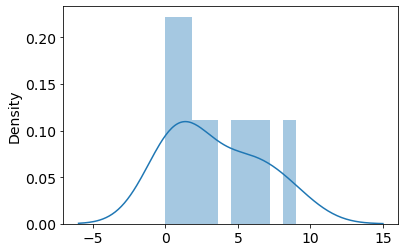

In [8]:
x = np.random.randint(0, 10, 10)
print(sorted(x))
print(f'median - {np.quantile(x, q=0.5)}\nmean - {np.mean(x)}\nmode - {stats.mode(x)[0][0]}')
sns.distplot(x, bins=10)

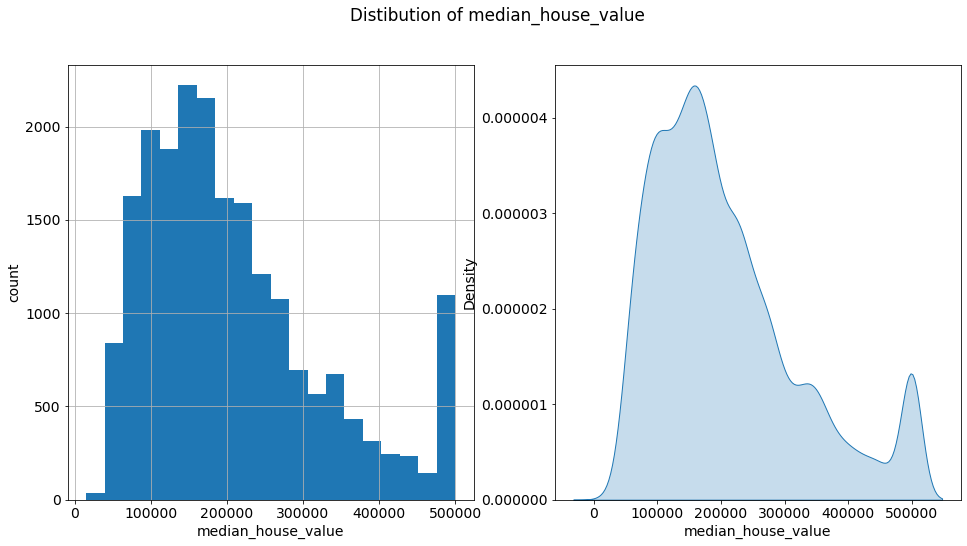

In [9]:
# Видим логнормальное распределение
# Пик справа - это выбросы или неправильно заполненные пропуски,
# Возможно, элитная недвижимость

plt.figure(figsize=(16, 8))
plt.subplot(121)
df['median_house_value'].hist(density=False, bins=20)
plt.ylabel('count')
plt.xlabel('median_house_value')


ax1 = plt.subplot(122)
sns.kdeplot(df['median_house_value'], shade=True, legend=False)
plt.xlabel('median_house_value')
formatter = ticker.ScalarFormatter()
formatter.set_scientific(False)
ax1.yaxis.set_major_formatter(formatter) 
plt.suptitle('Distibution of median_house_value ')
plt.show()


In [10]:
target_mean = round(df['median_house_value'].mean(), 2)
target_median = df['median_house_value'].median()
target_mode = df['median_house_value'].mode()[0]
print(f'mean - {target_mean}, median - {target_median}, mode - {target_mode}')

mean - 206854.97, median - 179700.0, mode - 500001.0


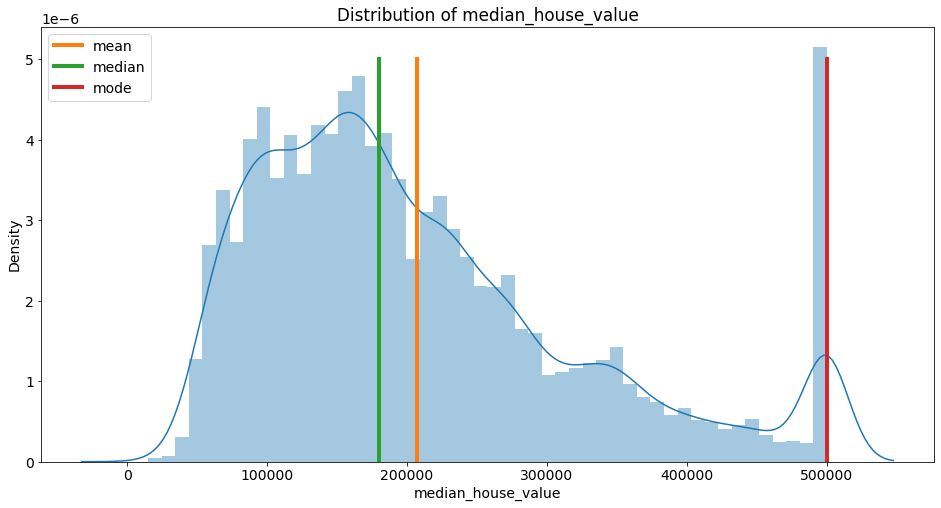

In [11]:
plt.figure(figsize=(16, 8))
sns.distplot(df['median_house_value'], bins=50)

y = np.linspace(0, 0.000005, 10)
plt.plot([target_mean] * 10, y, label='mean', linewidth=4)
plt.plot([target_median] * 10, y, label='median', linewidth=4)
plt.plot([target_mode] * 10, y, label='mode', linewidth=4)

plt.title('Distribution of median_house_value')
plt.legend()
plt.show()

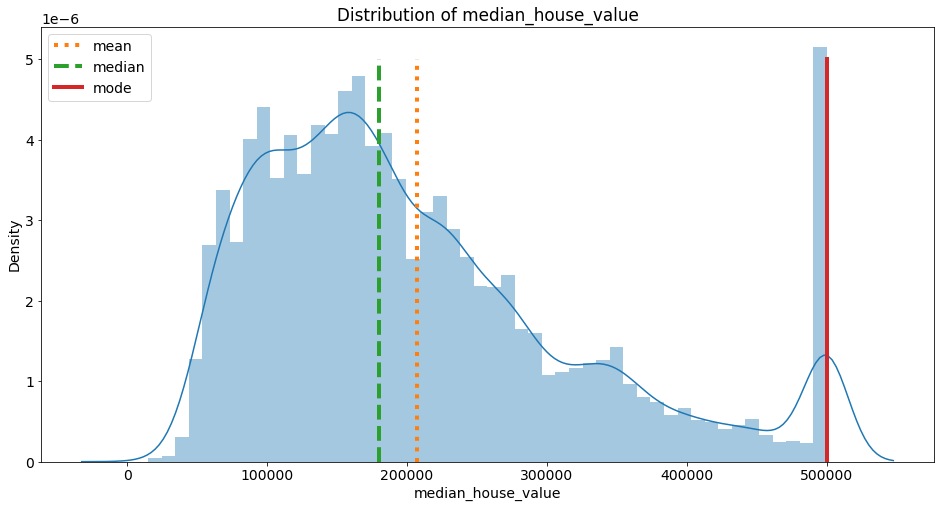

In [12]:
plt.figure(figsize=(16, 8))

sns.distplot(df['median_house_value'], bins=50)

y = np.linspace(0, 0.000005, 10)
plt.plot([target_mean] * 10, y, label='mean', linestyle=':', linewidth=4)
plt.plot([target_median] * 10, y, label='median', linestyle='--', linewidth=4)
plt.plot([target_mode] * 10, y, label='mode', linestyle='-', linewidth=4)

plt.title('Distribution of median_house_value')
plt.legend()
plt.show()

### 1. Adjusted mode

In [13]:
# Округлим до 10000
target_bins = df['median_house_value'] // 10000 * 10000
# 0 - 10000 --> 0
# 10001 - 20000 --> 1
# ...
target_adjusted_mode = target_bins.mode()[0]
target_adjusted_mode

160000.0

In [14]:
df['median_house_value'].value_counts()

500001.0    965
137500.0    122
162500.0    117
112500.0    103
187500.0     93
           ... 
359200.0      1
54900.0       1
377600.0      1
81200.0       1
47000.0       1
Name: median_house_value, Length: 3842, dtype: int64

In [15]:
target_bins

0        450000.0
1        350000.0
2        350000.0
3        340000.0
4        340000.0
           ...   
20635     70000.0
20636     70000.0
20637     90000.0
20638     80000.0
20639     80000.0
Name: median_house_value, Length: 20640, dtype: float32

In [16]:
target_bins.value_counts().iloc[:10]

160000.0    1005
500000.0     992
150000.0     970
90000.0      920
180000.0     853
130000.0     850
110000.0     847
170000.0     807
140000.0     802
80000.0      768
Name: median_house_value, dtype: int64

In [17]:
len(np.unique(target_bins))

50

In [18]:
np.unique(target_bins)

array([ 10000.,  20000.,  30000.,  40000.,  50000.,  60000.,  70000.,
        80000.,  90000., 100000., 110000., 120000., 130000., 140000.,
       150000., 160000., 170000., 180000., 190000., 200000., 210000.,
       220000., 230000., 240000., 250000., 260000., 270000., 280000.,
       290000., 300000., 310000., 320000., 330000., 340000., 350000.,
       360000., 370000., 380000., 390000., 400000., 410000., 420000.,
       430000., 440000., 450000., 460000., 470000., 480000., 490000.,
       500000.], dtype=float32)

mean - 206854.97, median - 179700.0, mode - 500001.0


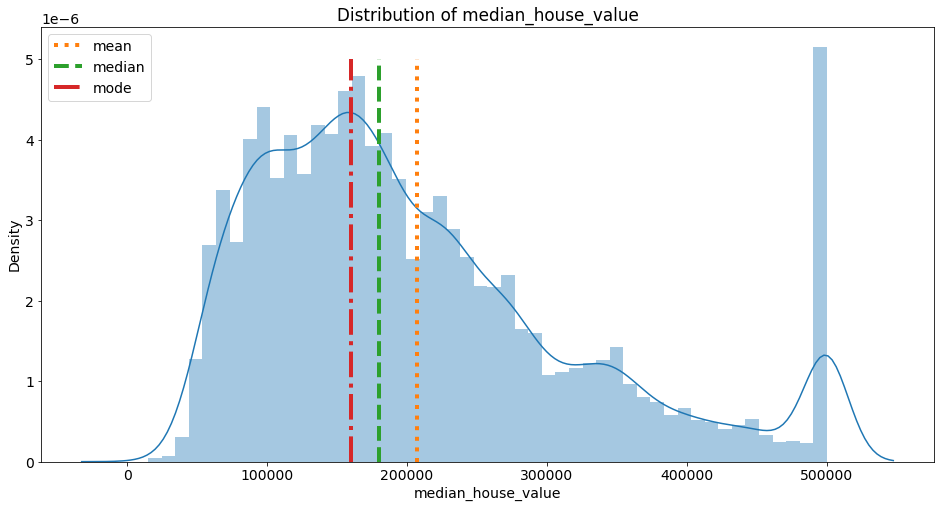

In [19]:
plt.figure(figsize=(16, 8))

sns.distplot(df['median_house_value'], bins=50)

y = np.linspace(0, 0.000005, 10)
plt.plot([target_mean] * 10, y, label='mean', linestyle=':', linewidth=4)
plt.plot([target_median] * 10, y, label='median', linestyle='--', linewidth=4)
plt.plot([target_adjusted_mode] * 10, y, label='mode', linestyle='-.', linewidth=4)

print(f'mean - {target_mean}, median - {target_median}, mode - {target_mode}')

plt.title('Distribution of median_house_value')
plt.legend()
plt.show()

### 2. Remove emissons

In [20]:
df['median_house_value'].value_counts()

500001.0    965
137500.0    122
162500.0    117
112500.0    103
187500.0     93
           ... 
359200.0      1
54900.0       1
377600.0      1
81200.0       1
47000.0       1
Name: median_house_value, Length: 3842, dtype: int64

mean - 192055.42, median - 173600.0, mode - 137500.0


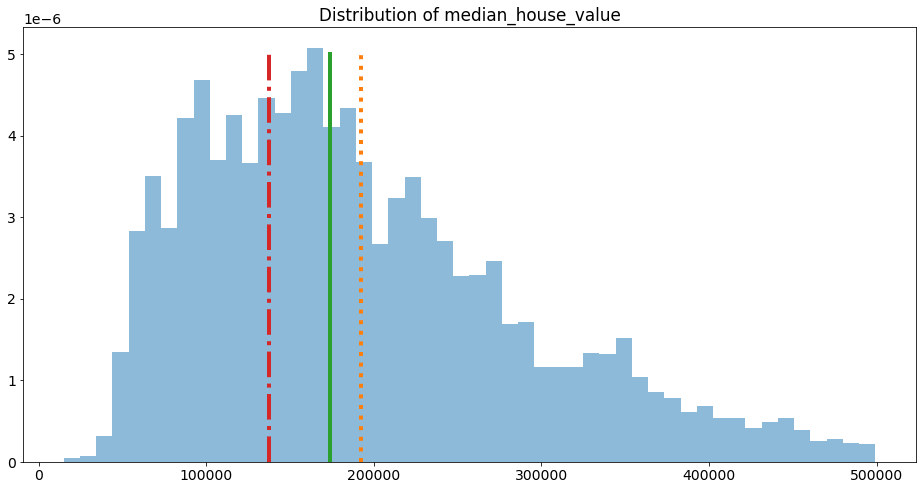

In [21]:
df = df[df['median_house_value'] < 500000]

target_mean = round(df['median_house_value'].mean(), 2)
target_median = df['median_house_value'].median()
target_mode = df['median_house_value'].mode()[0]
print(f'mean - {target_mean}, median - {target_median}, mode - {target_mode}')

plt.figure(figsize=(16, 8))
plt.hist(df['median_house_value'], density=True, bins=50, alpha=.5)
y = np.linspace(0, 0.000005, 10)
plt.plot([target_mean] * 10, y, label='mean', linestyle=':', linewidth=4)
plt.plot([target_median] * 10, y, label='median', linestyle='-', linewidth=4)
plt.plot([target_mode] * 10, y, label='mode', linestyle='-.', linewidth=4)

plt.title('Distribution of median_house_value')
plt.show()

## 2) Анализ признаков

### 2.1 Количественные признаки

In [22]:
# Выделим в отдельный dataframe
df_num_features = df.select_dtypes(include=['float64', 'float32', 'float16'])
df_num_features.drop('median_house_value', axis=1, inplace=True)

In [23]:
# housing_median_age - средний возраст дома
df_num_features

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,bedroom_share,population_per_room
0,-122.230003,37.880001,41.0,880.0,129.0,322.0,126.0,8.3252,14.659091,0.365909
1,-122.220001,37.860001,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,15.579659,0.338217
2,-122.239998,37.849998,52.0,1467.0,190.0,496.0,177.0,7.2574,12.951602,0.338105
3,-122.250000,37.849998,52.0,1274.0,235.0,558.0,219.0,5.6431,18.445839,0.437991
4,-122.250000,37.849998,52.0,1627.0,280.0,565.0,259.0,3.8462,17.209589,0.347265
...,...,...,...,...,...,...,...,...,...,...
20635,-121.089996,39.480000,25.0,1665.0,374.0,845.0,330.0,1.5603,22.462463,0.507508
20636,-121.209999,39.490002,18.0,697.0,150.0,356.0,114.0,2.5568,21.520803,0.510760
20637,-121.220001,39.430000,17.0,2254.0,485.0,1165.0,433.0,1.7000,21.517303,0.516859
20638,-121.320000,39.430000,18.0,1860.0,409.0,741.0,349.0,1.8672,21.989246,0.398387


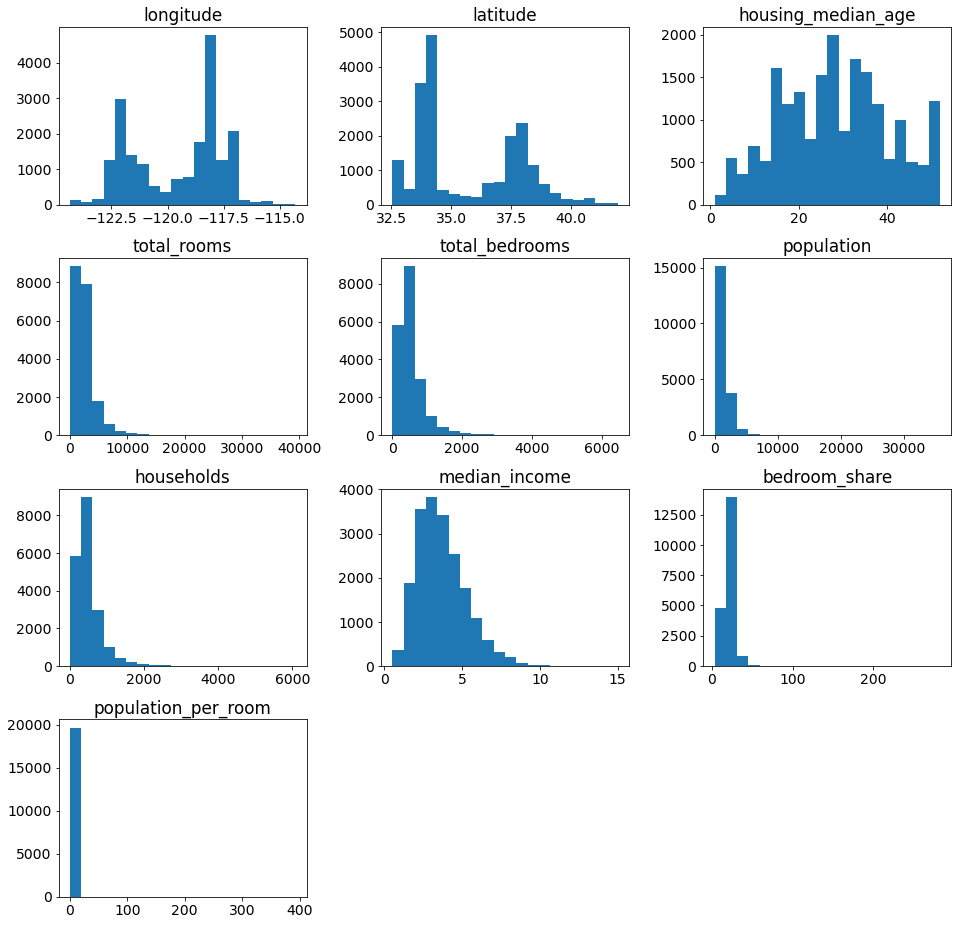

In [24]:
df_num_features.hist(figsize=(16, 16), bins=20, grid=False)
plt.show()

In [25]:
df['population_per_room'].describe()

count    19648.000000
mean         0.637403
std          2.981553
min          0.018109
25%          0.443528
50%          0.523444
75%          0.670273
max        392.631592
Name: population_per_room, dtype: float64

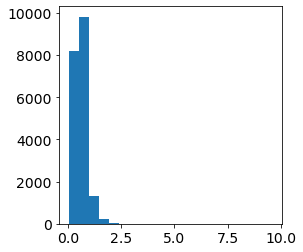

In [26]:
df.loc[df['population_per_room'] < 10, 'population_per_room'].\
    hist(figsize=(4,4), bins=20, grid=False)
plt.show()

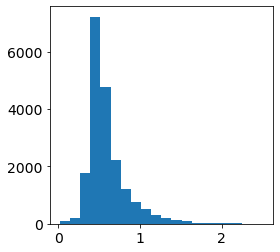

In [27]:
df.loc[df['population_per_room'] > 2.5, 'population_per_room'] = df['population_per_room'].median()
df.loc[df['population_per_room'] < 10, 'population_per_room'].\
    hist(figsize=(4,4), bins=20, grid=False)
plt.show()

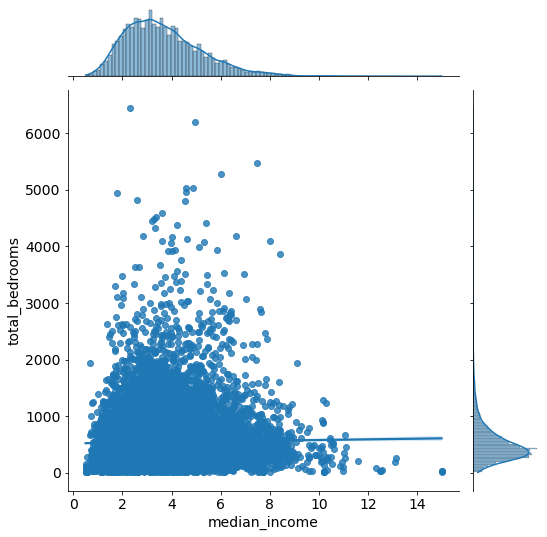

In [28]:
grid = sns.jointplot(df['median_income'], df['total_bedrooms'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

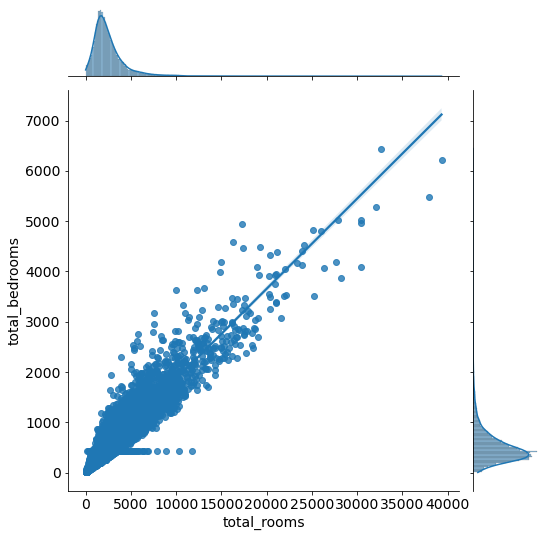

In [29]:
grid = sns.jointplot(df['total_rooms'], df['total_bedrooms'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

In [30]:
df['total_bedrooms'].median()

435.0

In [31]:
df[df['total_bedrooms'] == 435].shape[0] * 100 / df.shape[0]

1.2011400651465798

In [32]:
df[df['total_bedrooms'] == df['total_bedrooms'].median()].shape[0]

236

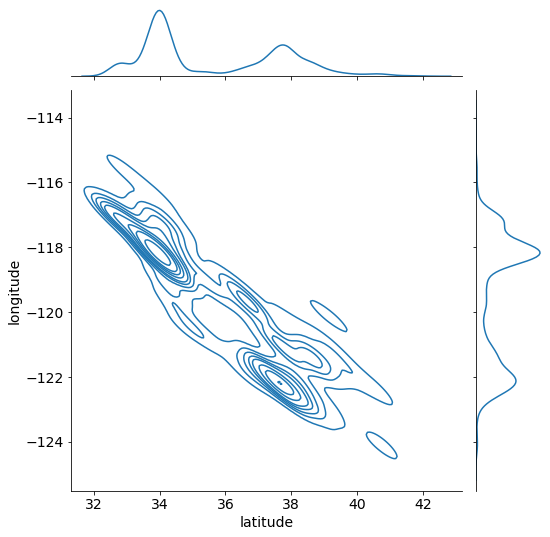

In [33]:
grid = sns.jointplot(df['latitude'], df['longitude'], kind='kde')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

In [34]:
df['city'] = (df['longitude'] > -120) * 1

In [35]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id,bedroom_share,population_per_room,-,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN,city
0,-122.230003,37.880001,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,0,14.659091,0.365909,0,0,0,0,1,0,0
1,-122.220001,37.860001,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,1,15.579659,0.338217,0,0,0,0,1,0,0
2,-122.239998,37.849998,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,2,12.951602,0.338105,0,0,0,0,1,0,0
3,-122.250000,37.849998,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,3,18.445839,0.437991,0,0,0,0,1,0,0
4,-122.250000,37.849998,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,4,17.209589,0.347265,0,0,0,0,1,0,0


#### Поиск выбросов с помощью box plot

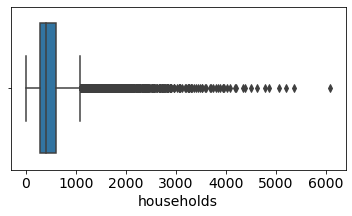

In [36]:
plt.figure(figsize=(6, 3))

sns.boxplot(df['households'], whis=1.5)

plt.xlabel('households')
plt.show()

In [37]:
df.loc[df['households'] >  800, 'households'] = df['households'].median()

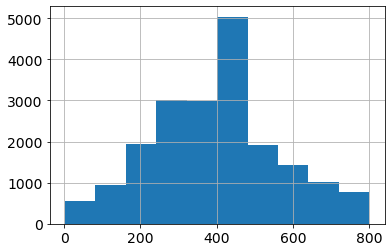

In [38]:
df['households'].hist()
plt.show()

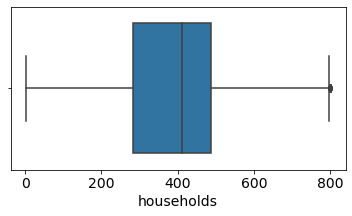

In [39]:
plt.figure(figsize=(6, 3))

sns.boxplot(df['households'], whis=1.5)

plt.xlabel('households')
plt.show()

### 2.2 Категориальные признаки

<1H OCEAN     8586
INLAND        6514
NEAR OCEAN    2434
NEAR BAY      2086
-               23
ISLAND           5
Name: ocean_proximity, dtype: int64


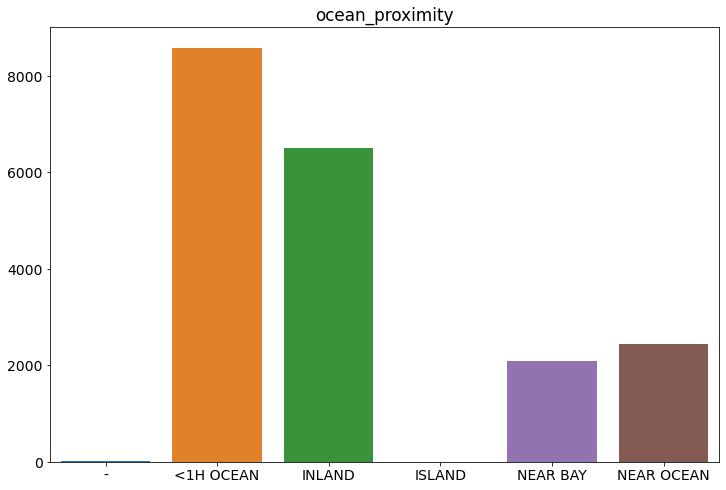

In [40]:
counts = df['ocean_proximity'].value_counts()
print(counts)
plt.figure(figsize=(12, 8))
plt.title('ocean_proximity')
sns.barplot(counts.index, counts.values)

plt.show()

### 2.3 Бинарные признаки

In [41]:
df_bin_features = df.select_dtypes(include='int64')

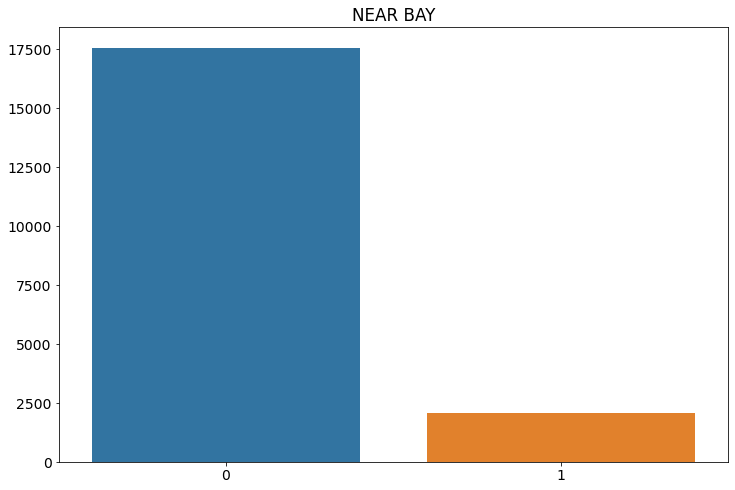

In [42]:
counts = df['NEAR BAY'].value_counts()

plt.figure(figsize=(12, 8))
plt.title('NEAR BAY')
sns.barplot(counts.index, counts.values)
plt.show()

### 2.4 Матрица корреляций

- Показывает линейную связь между переменными
- Изменяется от -1 до 1
- Корреляция - мера только линейной связи

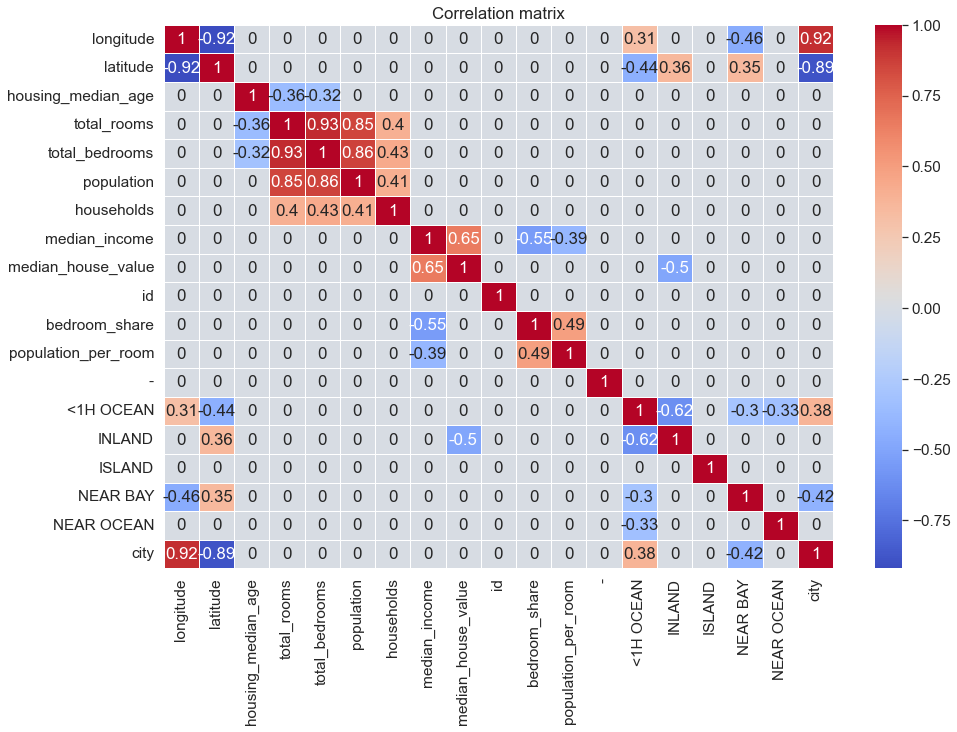

In [43]:
plt.figure(figsize=(15, 10))

sns.set(font_scale=1.4)
corr_matrix = df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < .3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

## 3. Анализ зависимости таргета от фичей

### 3.1 Количественные признаки

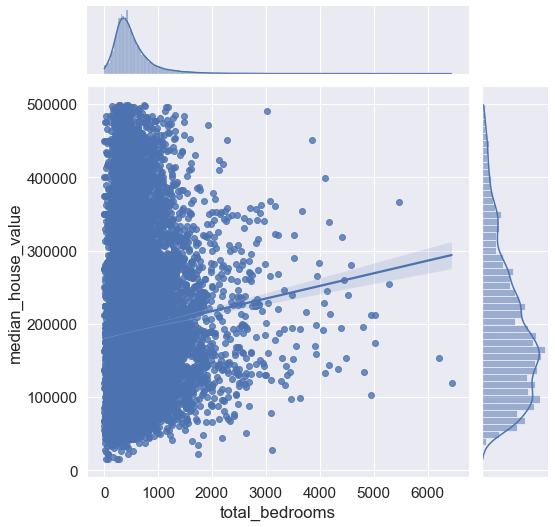

In [44]:
grid = sns.jointplot(df['total_bedrooms'], df['median_house_value'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)
plt.show()

In [45]:
df['many_bedrooms'] = (df['total_bedrooms'] > 3000) * 1

### latitude

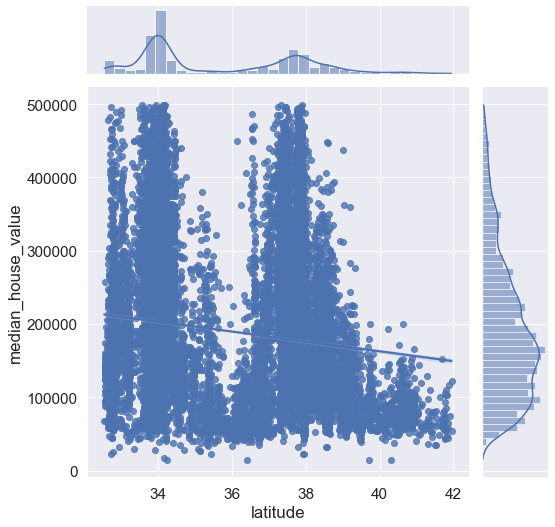

In [46]:
grid = sns.jointplot(df['latitude'], df['median_house_value'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)
plt.show()

График имеет две выраженные области (2 города). Имеет смысл рассмотреть их по отдельности.

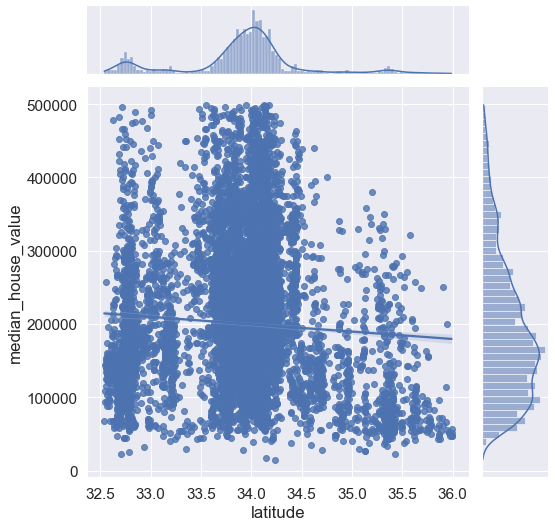

In [47]:
df_cut = df[df['latitude'] < 36]
grid = sns.jointplot(df_cut['latitude'], df['median_house_value'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)
plt.show()

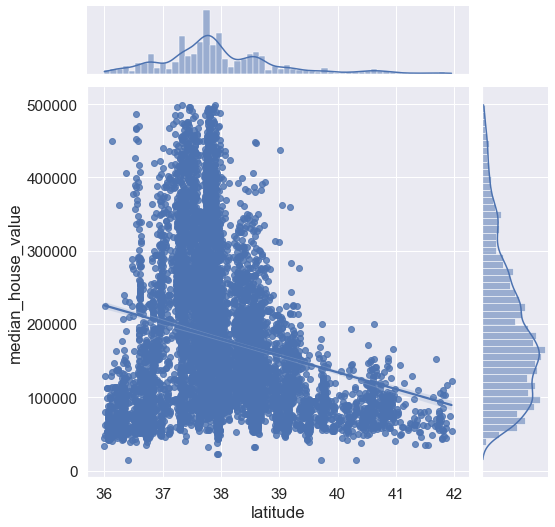

In [48]:
df_cut2 = df[df['latitude'] >= 36]
grid = sns.jointplot(df_cut2['latitude'], df['median_house_value'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)
plt.show()

### longitude

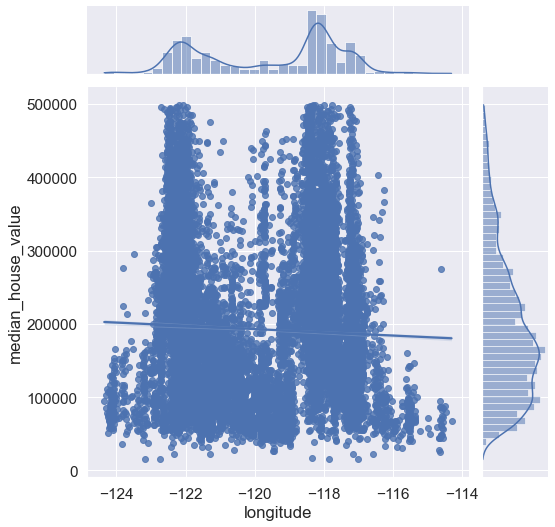

In [49]:
grid = sns.jointplot(df['longitude'], df['median_house_value'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)
plt.show()

Операции аналогичны latitude

### 3.2 Категориальные признаки

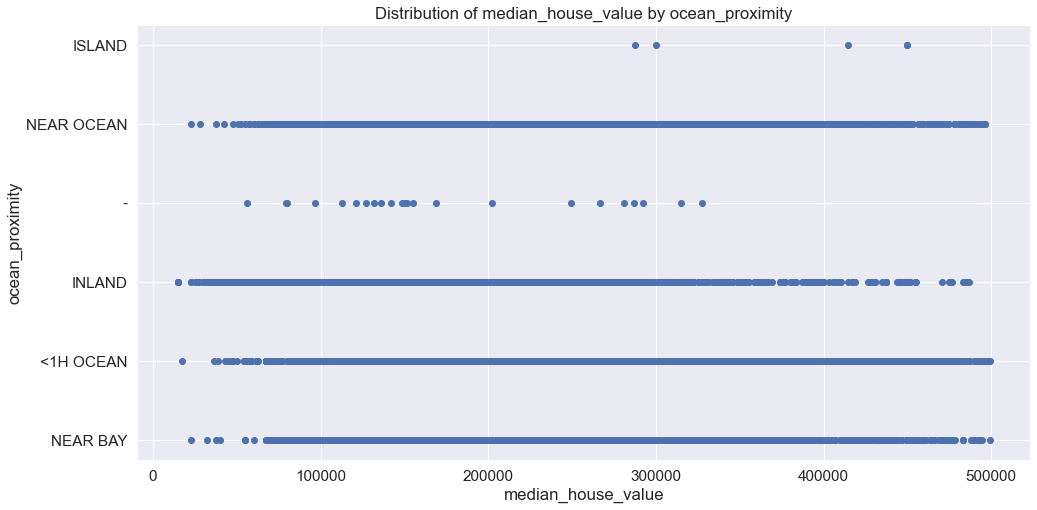

In [50]:
plt.figure(figsize=(16, 8))
plt.scatter(df['median_house_value'], df['ocean_proximity'])

plt.xlabel('median_house_value')
plt.ylabel('ocean_proximity')
plt.title('Distribution of median_house_value by ocean_proximity')
plt.show()

### box plot

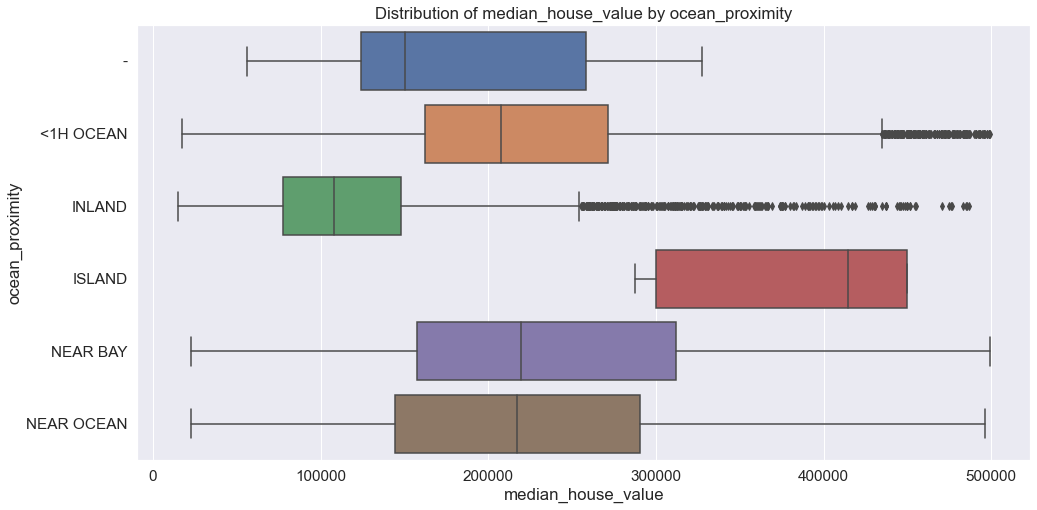

In [51]:
plt.figure(figsize=(16, 8))
sns.boxplot(df['median_house_value'], df['ocean_proximity'], whis=1.5)

plt.xlabel('median_house_value')
plt.ylabel('ocean_proximity')
plt.title('Distribution of median_house_value by ocean_proximity')
plt.show()

### Violin plot

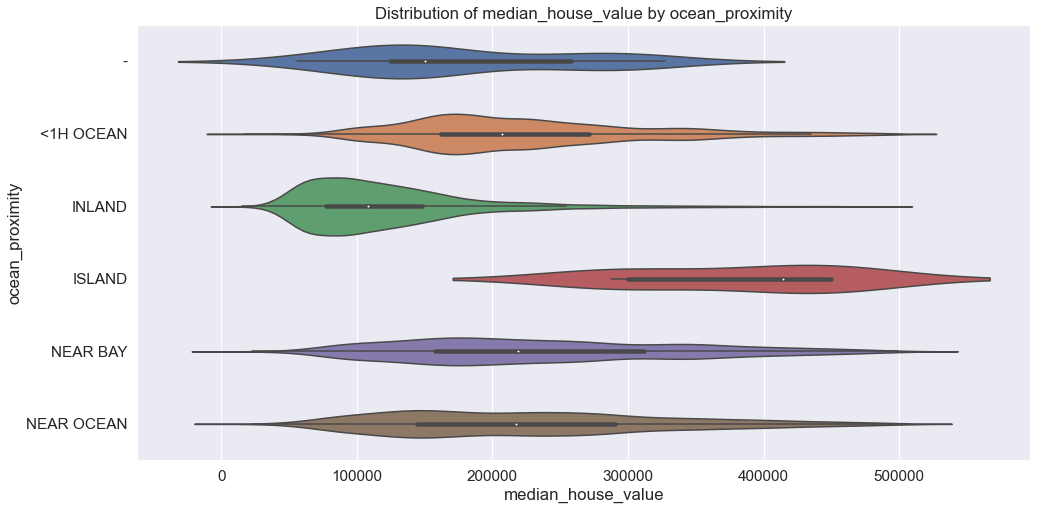

In [52]:
plt.figure(figsize=(16, 8))
sns.violinplot(df['median_house_value'], df['ocean_proximity'])
plt.xlabel('median_house_value')
plt.ylabel('ocean_proximity')
plt.title('Distribution of median_house_value by ocean_proximity')
plt.show()

### 3.3 Гео данные

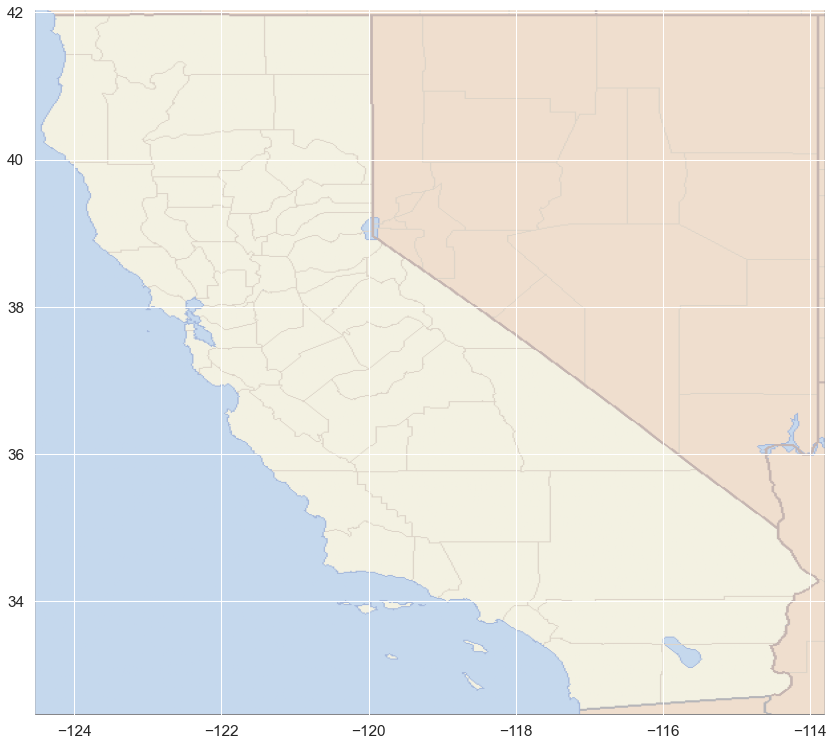

In [53]:
california_map = img.imread(CALIFORNIA_MAP_PATH)

plt.figure(figsize=(20, 13))
plt.imshow(california_map, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5)
plt.show()

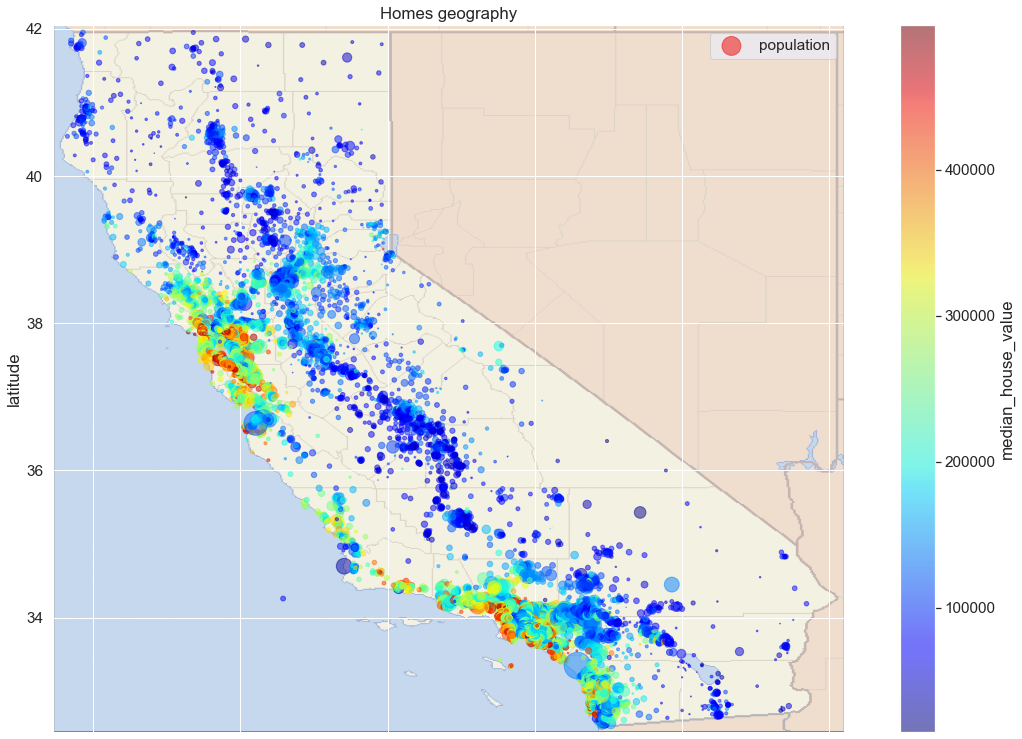

In [54]:
df.plot(kind='scatter', x='longitude', y='latitude',
        alpha=0.5, s=df['population'] / 50, label='population', c='median_house_value', cmap=plt.get_cmap('jet'), figsize=(20, 13))

plt.imshow(california_map, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5)
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('Homes geography')
plt.legend()
plt.show()

### Kepler

In [2]:
# !pip install keplergl==0.1.1

### Target encoding

In [8]:
df[['latitude', 'longitude', 'median_house_value']].head()

,latitude,longitude,median_house_value
0,37.88,-122.23,452600.0
1,37.86,-122.22,358500.0
2,37.85,-122.24,352100.0
3,37.85,-122.25,341300.0
4,37.85,-122.25,342200.0


In [9]:
df['latitude'] = np.round(df['latitude'], 0)
df['longitude'] = np.round(df['longitude'], 0)
df[['latitude', 'longitude', 'median_house_value']].head()

,latitude,longitude,median_house_value
0,38.0,-122.0,452600.0
1,38.0,-122.0,358500.0
2,38.0,-122.0,352100.0
3,38.0,-122.0,341300.0
4,38.0,-122.0,342200.0


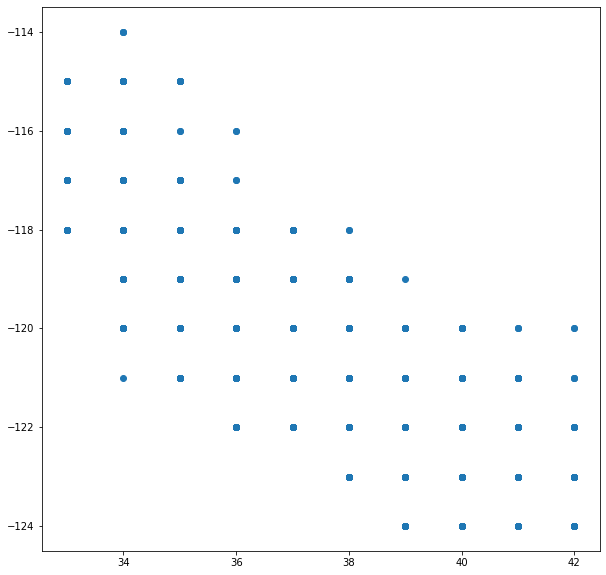

In [10]:
plt.figure(figsize=(10, 10))
plt.scatter(df['latitude'], df['longitude'])
plt.show()

In [12]:
df[['latitude', 'longitude']].drop_duplicates().shape[0]

58

In [7]:
df_g = df.groupby(['latitude', 'longitude'])['median_house_value'].mean().reset_index()
df_g

,latitude,longitude,median_house_value
0,32.54,-117.04,67500.0
1,32.55,-117.09,144400.0
2,32.55,-117.06,108800.0
3,32.55,-117.04,93200.0
4,32.56,-117.12,257700.0
...,...,...,...
12590,41.86,-121.93,44000.0
12591,41.88,-123.83,116700.0
12592,41.92,-124.16,75000.0
12593,41.95,-124.14,122400.0
